In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

data_path = Path("../data")

## Basic Explo

Index(['experiment_id', 'protein_name', 'uniprot_id', 'pdb_id', 'chain',
       'position', 'wild_type', 'mutation', 'ddG', 'dTm', 'is_curated', 'type',
       'derived_type', 'interpro_families', 'conservation', 'is_essential',
       'correlated_pairs', 'back_to_consensus', 'secondary_structure', 'asa',
       'is_in_catalytic_pocket', 'tunnels', 'is_in_bottleneck', 'b_factor',
       'method', 'method_details', 'technique', 'technique_details', 'pH',
       'tm', 'notes', 'publication_doi', 'publication_pubmed', 'hsw_job_id',
       'datasets', 'sequence'],
      dtype='object')
Total no of proteins: 235 
Proteins w/ tm values: 206 



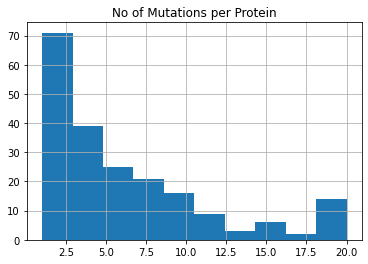

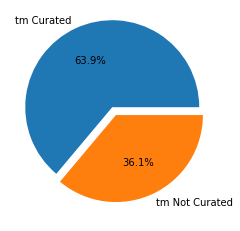

In [2]:
df = pd.read_csv(data_path / "fireprotdb_results.csv", low_memory=False)
df = df.drop_duplicates()
total_prots = len(df.sequence.unique())

df = df[df.tm.isin(df.tm.dropna())]
tm_prots = len(df.sequence.unique())

mutations_per_prot = df.groupby(by="sequence").mutation.unique()

print(df.columns)
print(f"Total no of proteins: {total_prots} \nProteins w/ tm values: {tm_prots} \n")

ax = mutations_per_prot.apply(len).hist()
ax.set_title("No of Mutations per Protein");
plt.show() 

y = [df.is_curated.sum(), len(df) - df.is_curated.sum()]
explode = (0.1, 0)
labels = ("tm Curated","tm Not Curated")

plt.pie(y, explode=explode, labels=labels, autopct='%1.1f%%')
plt.show() 

In [3]:
df.technique_details.unique()

array([nan, 'CD', 'DSC', 'Activity', 'Fluorescence', 'Absorbance', 'NMR',
       'CD, Fluorescence', 'Absorbance, CD, Fluorescence',
       'Quantitaive cysteine reactivity'], dtype=object)

In [4]:
df.head()

,experiment_id,protein_name,uniprot_id,pdb_id,chain,position,wild_type,mutation,ddG,dTm,...,technique,technique_details,pH,tm,notes,publication_doi,publication_pubmed,hsw_job_id,datasets,sequence
0,LL000001,Haloalkane dehalogenase,P59336,1CQW,A,245,V,L,NaN,2.1,...,NaN,NaN,NaN,52.5,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
1,LL000002,Haloalkane dehalogenase,P59336,1CQW,A,95,L,V,NaN,-0.4,...,NaN,NaN,NaN,50.0,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
2,LL000004,Haloalkane dehalogenase,P59336,1CQW,A,176,C,F,NaN,5.2,...,NaN,NaN,NaN,55.6,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
3,LL000005,Haloalkane dehalogenase,P59336,1CQW,A,171,G,Q,NaN,3.1,...,NaN,NaN,NaN,53.5,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
4,LL000006,Haloalkane dehalogenase,P59336,1CQW,A,148,T,L,NaN,1.1,...,NaN,NaN,NaN,51.5,NaN,NaN,NaN,xfyu58,NaN,MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...


## Get Mutations Sequences

In [5]:
sequences = []# set()

#TODO: TEST IF MUTATION IS CORRECT
nans = 0
for row in tqdm(df.itertuples(), total = len(df)):
    mutation = row.mutation
    position = row.position
    original_seq = row.sequence

    new_sequence = original_seq[:position - 1] + mutation + original_seq[position:]
    if mutation == original_seq[position - 1] or str(new_sequence) == str(original_seq) or (new_sequence in sequences):
        # print(row.Index)
        new_sequence = None
        nans += 1
    sequences.append(new_sequence)

df["mutated_sequences"] = sequences

100%|██████████| 7481/7481 [00:00<00:00, 30625.10it/s]


In [6]:
len(sequences), len(set(sequences)) # same protein and same mutation multiple times? w/ different values? how can this be possible?? ==> see: https://loschmidt.chemi.muni.cz/fireprotdb/mutation/6154

(7481, 4473)

## Filtering to extract embeddings

In [7]:
data = df[["mutated_sequences", "tm"]]
data.columns = ["sequences", "labels"]
data = data[data["sequences"].str.len() < 1000]
data = data[data.columns[::-1]]
data = data.dropna()

data, len(data)

(       labels                                          sequences
 0        52.5  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
 1        50.0  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
 2        55.6  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
 3        53.5  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
 4        51.5  MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSY...
 ...       ...                                                ...
 16877    22.0  MAALAGAIVVTGGVGSYAADEPIDLEKLEEKRDKENVGNLPKFDNE...
 16878    22.0  MAALAGAIVVTGGVGSYAADEPIDLEKLEEKRDKENVGNLPKFDNE...
 16879    25.0  MEKEKKVKYFLRKSAFGLASVSAAFLVGSTVFAVDSPIEDTPIIRN...
 16881    25.0  MPSSVSWGILLLAGLCCLVPVSLAEDPQGDAAQKTDTSHHDQDHPT...
 16888    25.0  MKIKTGARILALSALTTMMFSASALAKIEEGKLVIWINGDKGYNGL...
 
 [4338 rows x 2 columns],
 4338)

In [8]:
len(data.sequences.unique())

4338

## Embedding Extraction + H5 Dataset

In [9]:
from protera_stability.data import ProteinStabilityDataset
from protera_stability.proteins import EmbeddingExtractor1D

args_dict = {
    "model_name": "esm1b_t33_650M_UR50S",
    "base_path": data_path,
    "gpu": True,
}
emb_extractor = EmbeddingExtractor1D(**args_dict)
# embeddings = emb_extractor.generate_embeddings(
#     [""],
#     data=data,
#     path_out=f"embeddings_fireprot",  # data_path / "embeddings_fireprot".pkl
#     bs=1,
# )

dataset = emb_extractor.generate_datasets(
    [""],
    h5_stem="tm_fireprot",
    embedding_file=f"embeddings_tm_fireprot",  # data_path / "embeddings_fireprot".pkl
    data=data
)

# dataset = ProteinStabilityDataset(data_path / f"stability_fireprot.h5",  ret_dict=False)
# len(dataset)

Using cache found in /home/roberto/.cache/torch/hub/facebookresearch_esm_master


In [10]:
dataset.keys(), len(dataset["embeddings"])

(<KeysViewHDF5 ['embeddings', 'labels', 'sequences']>, 4338)

In [11]:
dataset["embeddings"][:5], dataset["labels"][:5], dataset["sequences"][:5]

(array([[ 0.2350897 , -0.25447264,  0.28473607, ..., -0.04676087,
          0.07022724, -0.01316316],
        [ 0.22206414, -0.25040242,  0.2857153 , ..., -0.03801018,
          0.07393236, -0.01647799],
        [ 0.23157649, -0.25188828,  0.284555  , ..., -0.04157856,
          0.0643125 , -0.01581165],
        [ 0.23130716, -0.25267693,  0.28191715, ..., -0.04323569,
          0.07054537, -0.01639866],
        [ 0.23388666, -0.25644046,  0.28717238, ..., -0.04394579,
          0.06922317, -0.00828897]], dtype=float32),
 array([52.5, 50. , 55.6, 53.5, 51.5]),
 array([b'MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSYLWRNIIPHVAPSHRCIAPDLIGMGKSDKPDLDYFFDDHVRYLDAFIEALGLEEVVLVIHDWGSALGFHWAKRNPERVKGIACMEFIRPIPTWDEWPEFARETFQAFRTADVGRELIIDQNAFIEGVLPKCVVRPLTEVEMDHYREPFLKPVDREPLWRFPNEIPIAGEPANIVALVEAYMNWLHQSPVPKLLFWGTPGLLIPPAEAARLAESLPNCKTVDIGPGLHYLQEDNPDLIGSEIARWLPGLA',
        b'MSEIGTGFPFDPHYVEVLGERMHYVDVGPRDGTPVLFLHGNPTSSYLWRNIIPHVAPSHRCIAPDLIGMGKSDKPDLDYFFDDHVRYLDAFIEAVGLEEVVLVIHDWGSALGFHWA